This is a notebook but can be converted to script for prediction on subset
Subset size has to be fixed at 64x64
Need some more discussion on this

In [1]:

#Importing modules and model for prediction

from typing import Optional, Tuple
import torch
from pytorch_lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np
import xarray as xr
from collections import defaultdict
from lit_module import plUNET
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Load the model from the checkpoint
model = plUNET.load_from_checkpoint(checkpoint_path="/home/geosys/sarunet/landslide-sar-unet/lightning_logs/version_29/checkpoints/epoch=9-step=40.ckpt")
model.eval()


/home/geosys/mambaforge/envs/xdeep/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/geosys/mambaforge/envs/xdeep/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


plUNET(
  (net): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [3]:

#Needed to modify this as the original function is based on reading zarr from a path, here we are directly passing the subset generated and served through xcube
def before_after_ds(ds, ba_vars, aggregation, timestep_length, event_start_date, event_end_date):
    # ds = xr.open_zarr(ds_path) #For us not requried
    for var in ba_vars:
        ds[var] = np.log(ds[var])
    ds = ds.where((ds['sat:orbit_state'] == 'd').compute(), drop=True)
    before_ds = ds.drop_dims('timepair').sel(timestep=slice(None, event_start_date))
    after_ds = ds.drop_dims('timepair').sel(timestep=slice(event_end_date, None))

    if timestep_length < len(before_ds['timestep']):
        before_ds = before_ds.isel(timestep=range(-1 - timestep_length, -1))

    if timestep_length < len(after_ds['timestep']):
        after_ds = after_ds.isel(timestep=range(timestep_length))

    if aggregation == 'mean':
        before_ds = before_ds.mean(dim=('timestep'))
        after_ds = after_ds.mean(dim=('timestep'))
    elif aggregation == 'median':
        before_ds = before_ds.median(dim=('timestep'))
        after_ds = after_ds.median(dim=('timestep'))

    before_after_vars = []
    for suffix in ['before', 'after']:
        for var in ba_vars:
            before_after_vars.append(f'{var}_{suffix}')
    the_ds = before_ds.rename_vars({var: f'{var}_before' for var in ba_vars})
    for var in ba_vars:
        the_ds[f'{var}_after'] = after_ds[var]
    for var in the_ds.data_vars:
        the_ds[f'{var}_mean'] = the_ds[var].mean()
        the_ds[f'{var}_std'] = the_ds[var].std()
    return the_ds.load()



In [4]:
#xcube details
import requests
from IPython.display import JSON
server_url = "http://172.31.90.130:8081" #server running url 

def GET(path: str): 
    return JSON(requests.get(server_url + path).json())

def PUT(path: str, request: dict): 
    return JSON(requests.put(server_url + path, json=request).json())





In [6]:
#Fetch available datasets
GET("/datasets")

<IPython.core.display.JSON object>

In [7]:
#Request to xcube server to create a subset and output named as Hokkaido_64.zarr
PUT("/compute/jobs", request={
    "operationId": "spatial_subset",
    "parameters": {
        "dataset": "hokkaido_japan.zarr",
        "bbox": [569183.6775495909, 4741545.603319767, 569823.7636464146, 4742186.711696316]        
    },
    "output": {
        "datasetId": "Hokkaido_64.zarr",
        "title": "Hokkaido_64.zarr"
    }
})

<IPython.core.display.JSON object>

In [8]:
#job status failed/completed
GET("/compute/jobs")

<IPython.core.display.JSON object>

In [9]:
#fetching available datasets
GET("/datasets") 

<IPython.core.display.JSON object>

In [10]:

# mandatory xcube store imports, serving the new subset and opening an store (following what they have given in example)
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.store import new_data_store
store = new_data_store(
   "s3",
   root="datasets", 
   storage_options=dict(
       anon=True, 
       client_kwargs=dict(
           endpoint_url=server_url + "/s3/"
       )
   )
)
local_subset = store.open_data("Hokkaido_64.zarr")

In [13]:
# local_subset


In [15]:
# local_subset.data_vars

In [16]:
BeforeAfterDS = before_after_ds(ds=local_subset, ba_vars=['vv', 'vh'],aggregation='mean',timestep_length=3,event_start_date='20180905',event_end_date='20180907')

/home/geosys/mambaforge/envs/xdeep/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [17]:
req_variables=['vv_before','vv_after','vh_before','vh_after']
test_data = BeforeAfterDS[req_variables]
# test_data

In [18]:
np_array = test_data.to_array().values
# np_array

In [19]:
# np_array.shape

In [20]:
torch_tensor = torch.from_numpy(np_array)
# torch_tensor

In [21]:
torch_tensor=torch_tensor[None,:,:,:]
# torch_tensor.shape

In [22]:
predict = model(torch_tensor)

In [23]:
# predict.size()

In [24]:
predict_np_array = predict.detach().numpy()
# predict_np_array

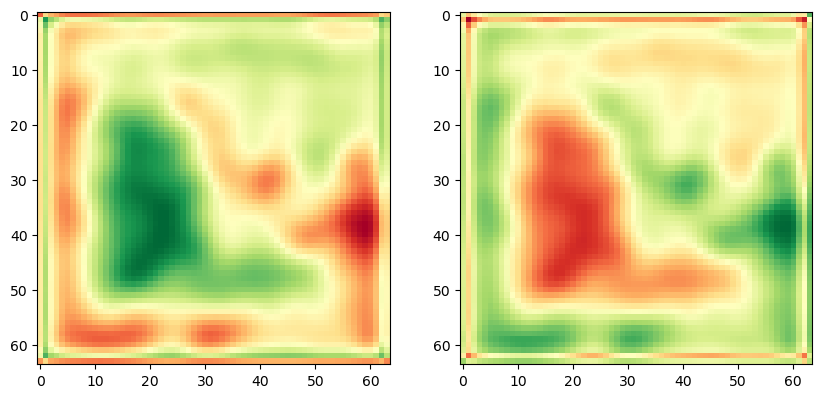

In [25]:

arr = predict_np_array

transposed_arr = np.transpose(arr, (2, 3, 1, 0))

squeezed_arr = np.squeeze(transposed_arr, axis=3)

# Plot the resulting array
# This will create 2 plots, one for each channel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axs[i].imshow(squeezed_arr[:, :, i], cmap='RdYlGn')
plt.show()